In [1]:
from spacerocks.spacerock import SpaceRock, RockCollection, Origin
from spacerocks.observing import Observatory, DetectionCatalog
from spacerocks.spice import SpiceKernel
from spacerocks.time import Time
from spacerocks.nbody import Simulation, Integrator, Force

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np

kernel = SpiceKernel()
kernel.load("/Users/kjnapier/data/spice/latest_leapseconds.tls")
kernel.load("/Users/kjnapier/data/spice/de440s.bsp")

origin = Origin.ssb()

In [2]:
N = 1
rocks = RockCollection.random(N)

epoch = Time.now()
rocks.analytic_propagate(epoch)

planets_names = ["sun", 
                 "jupiter barycenter", 
                 "saturn barycenter", 
                 "uranus barycenter", 
                 "neptune barycenter"]

planets = [SpaceRock.from_spice(name, epoch, frame="ECLIPJ2000", origin=origin) for name in planets_names]

In [3]:
sim = Simulation()

sim.set_epoch(epoch)
sim.set_frame("ECLIPJ2000")
sim.set_origin(origin)
sim.set_integrator(Integrator.ias15(timestep=20.0))

sim.add_force(Force.newtonian_gravity())

for planet in planets:
    sim.add(planet)
    
for rock in rocks:
    sim.add(rock)



sim.move_to_center_of_mass()
E0 = sim.energy()


In [4]:
dts = np.linspace(0, 365.25 * 100_000, 10_000)
epochs = [epoch + dt for dt in dts]

In [5]:
particle_snapshots = []
energies = []
for epoch in epochs:
    sim.integrate(epoch)
    particle_snapshots.append(sim.particles)
    energies.append(sim.energy())

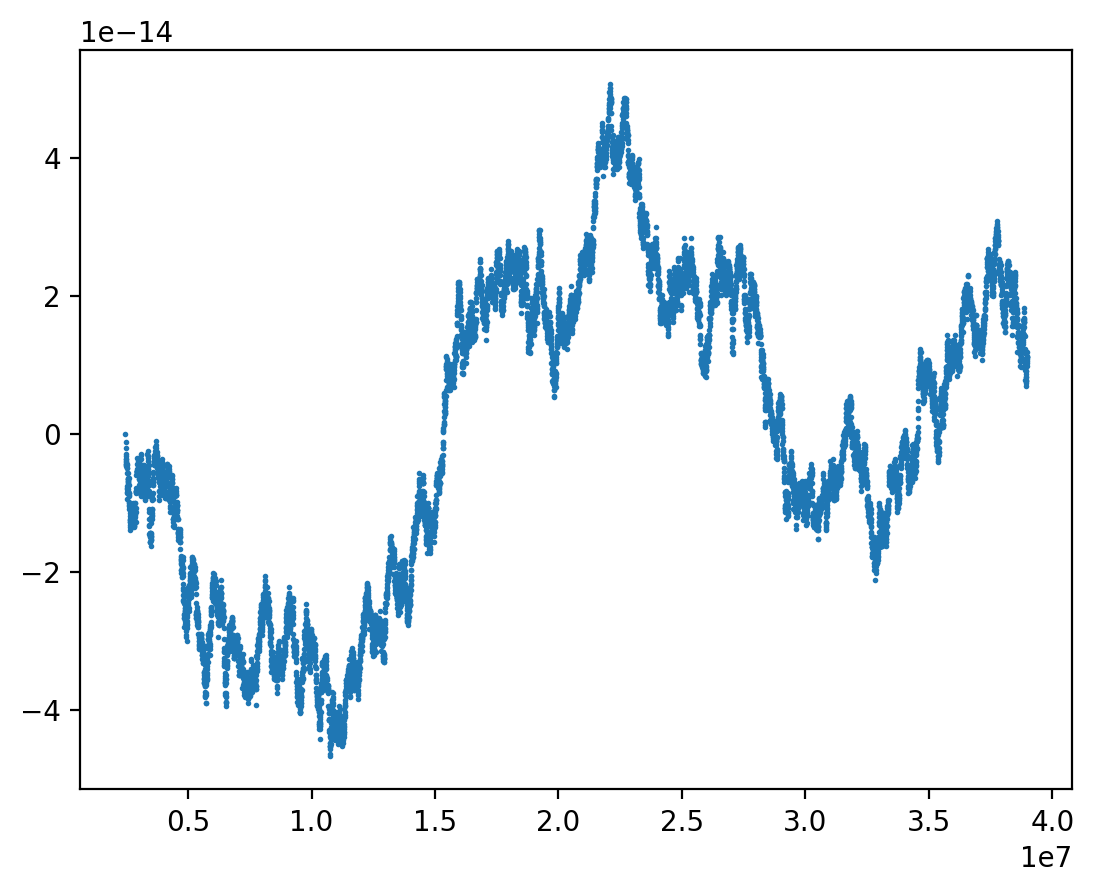

In [6]:
plt.scatter([epoch.epoch for epoch in epochs], (np.array(energies) - E0) / E0, s=1)

In [7]:
for p in particle_snapshots:
    p.calculate_orbit()

(2460529.280127315, 38985529.28012732)

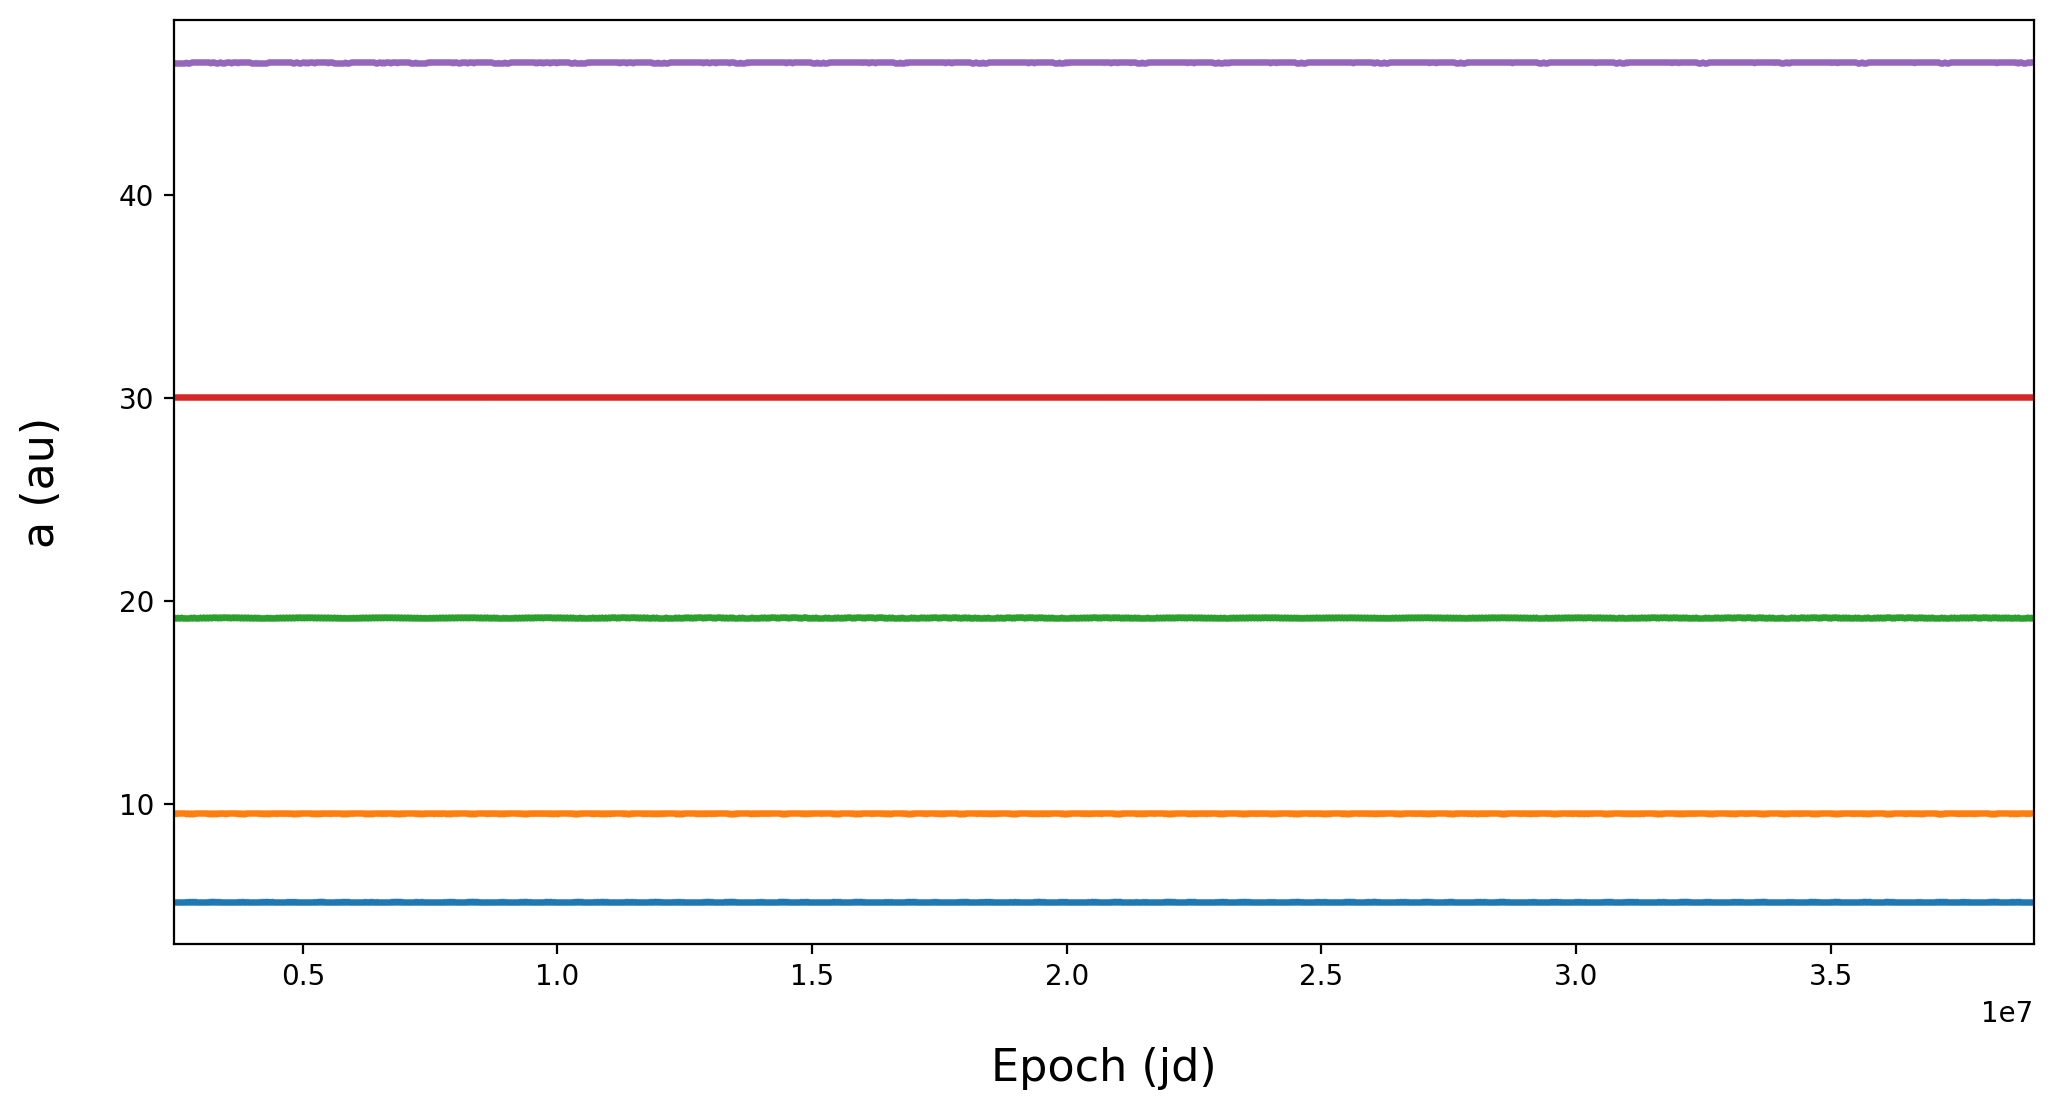

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))
for idx in range(1, sim.particles.len()):
    semimajors = [p.a[idx] for p in particle_snapshots]
    epochs = [p[idx].epoch.epoch for p in particle_snapshots]
    
    ax.scatter(epochs, semimajors, s=1, alpha=0.5)

ax.set_xlabel('Epoch (jd)', fontsize=16, labelpad=20)
ax.set_ylabel('a (au)', fontsize=16, labelpad=20)
ax.set_xlim(epochs[0], epochs[-1])

In [9]:
sim.particles.len()

6

(0.0, 0.1536853741157166)

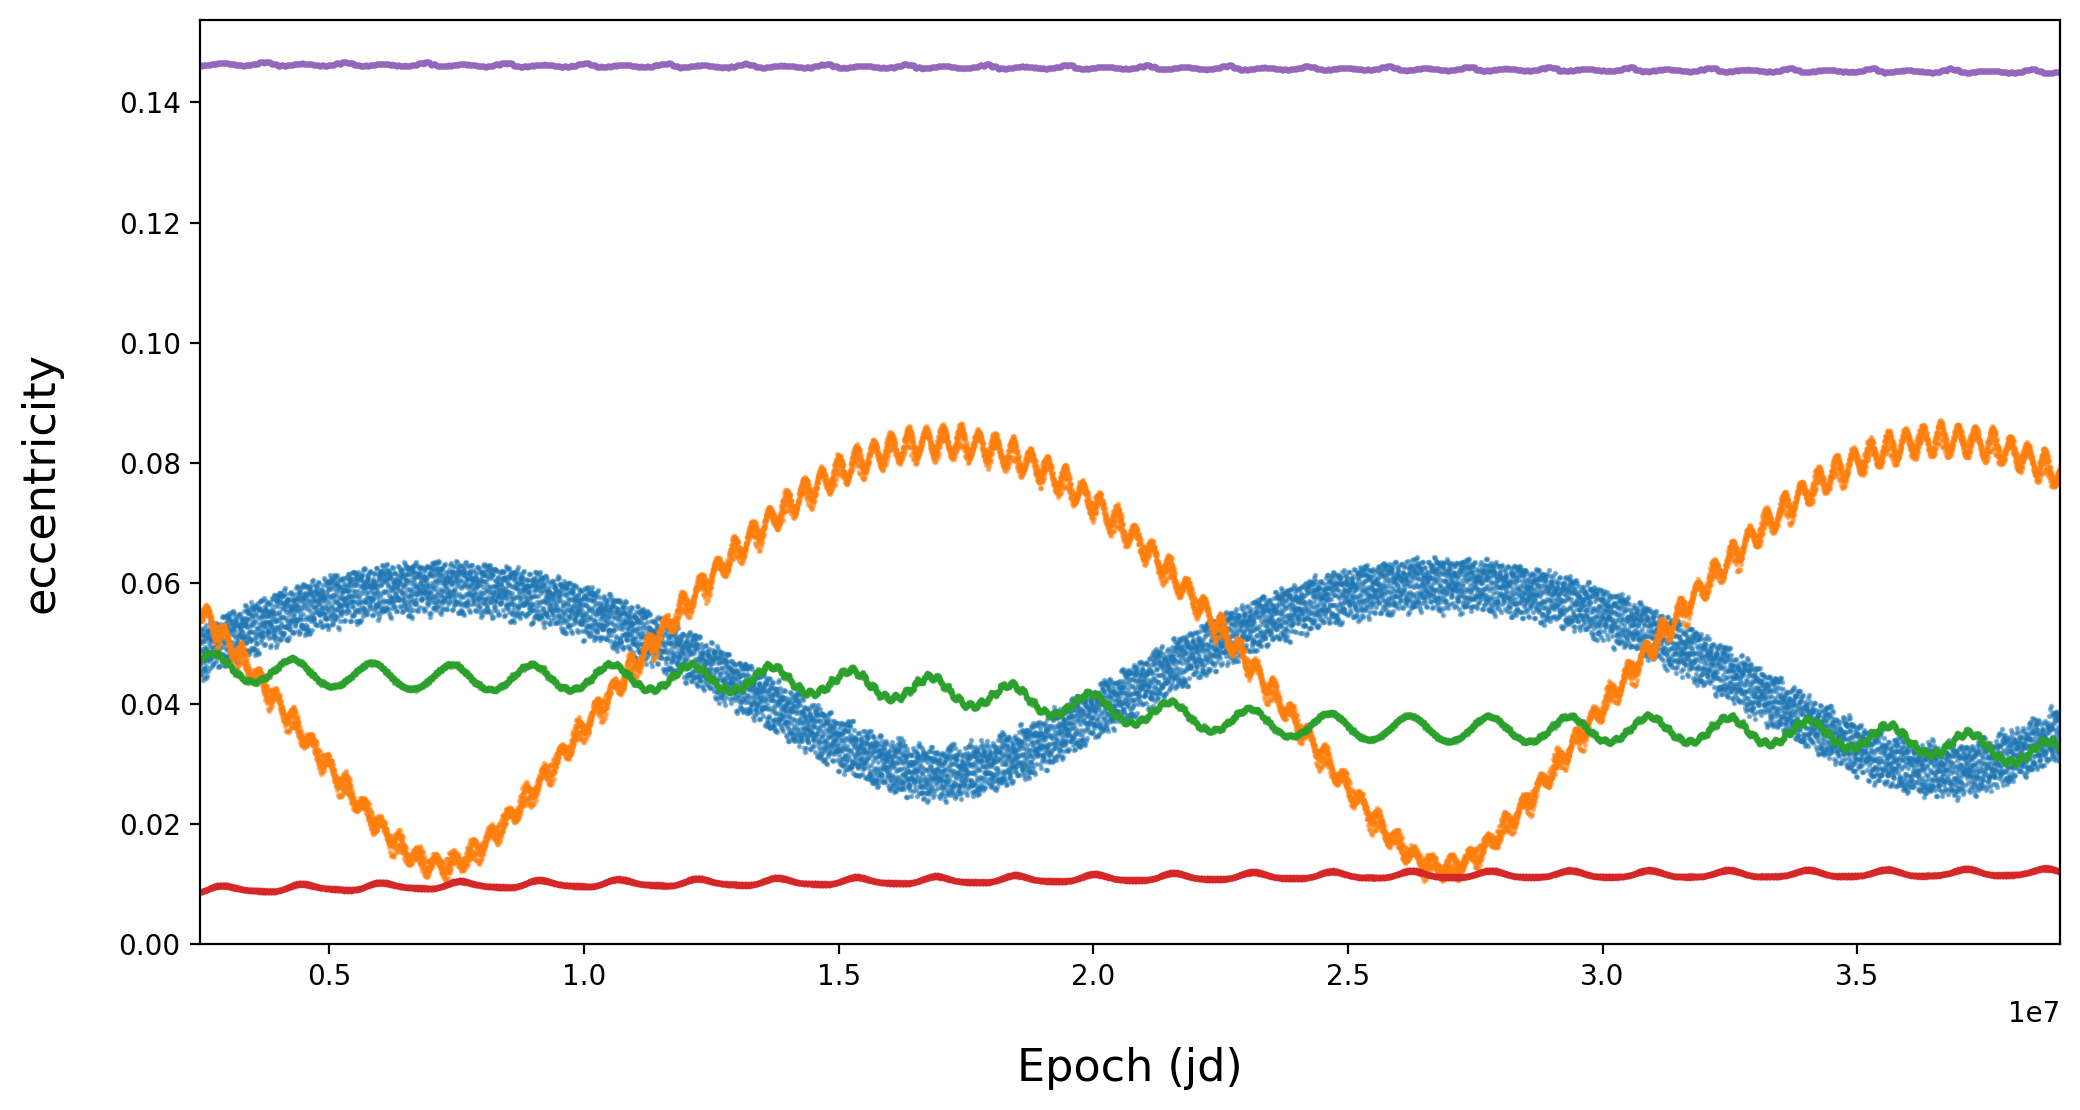

In [10]:
fig, ax = plt.subplots(figsize=(12, 6))
for idx in range(1, sim.particles.len()):
    semimajors = [p.e[idx] for p in particle_snapshots]
    epochs = [p[idx].epoch.epoch for p in particle_snapshots]
    
    ax.scatter(epochs, semimajors, s=1, alpha=0.5)

ax.set_xlabel('Epoch (jd)', fontsize=16, labelpad=20)
ax.set_ylabel('eccentricity', fontsize=16, labelpad=20)
ax.set_xlim(epochs[0], epochs[-1])
ax.set_ylim(bottom=0.0)

In [11]:
x, y, z = np.ravel([p.x for p in particle_snapshots]), np.ravel([p.y for p in particle_snapshots]), np.ravel([p.z for p in particle_snapshots])

(-50.0, 50.0)

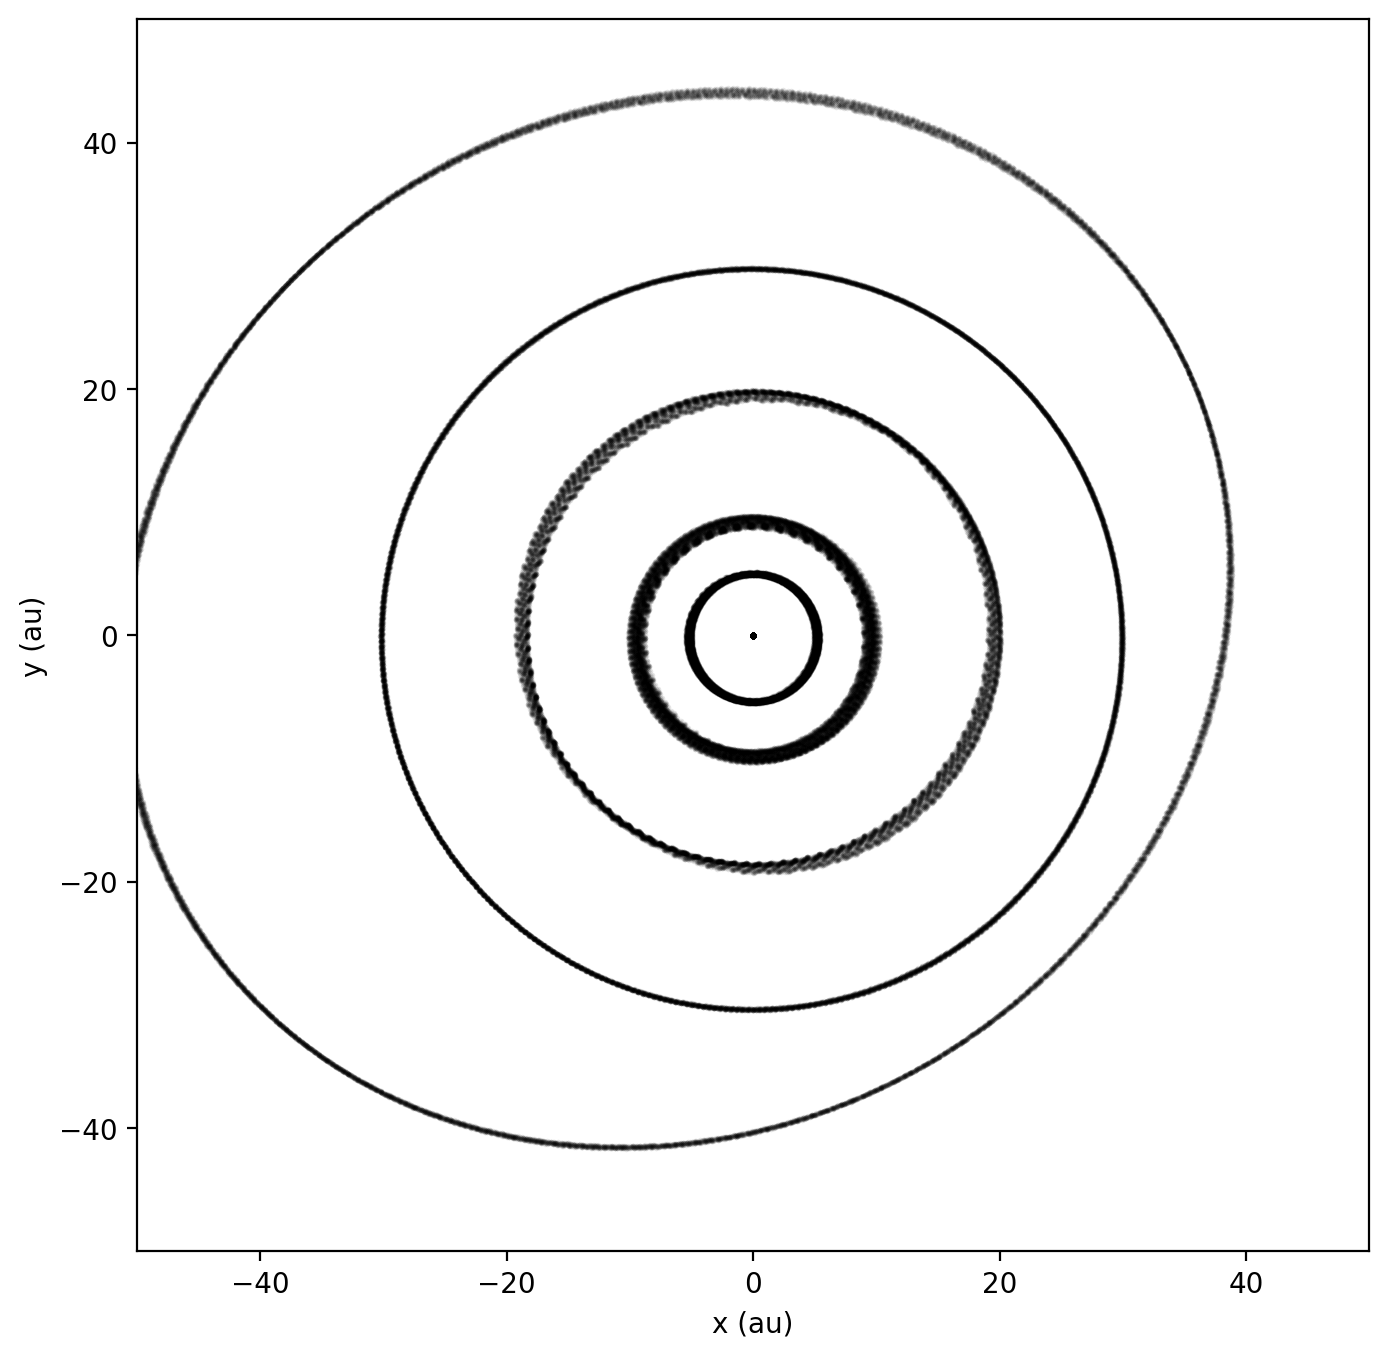

In [12]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(x, y, s=1, alpha=0.1, color='black')
ax.set_aspect('equal')
ax.set_xlabel("x (au)")
ax.set_ylabel("y (au)")
ax.set_xlim(-50, 50)
ax.set_ylim(-50, 50)

In [16]:
%%timeit
sim.step()

237 µs ± 7.08 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [17]:
kernel.unload()

In [73]:
import rebound

In [74]:
sim = rebound.Simulation()
sim.units = ('day', 'AU', 'Msun')

for planet in planets:
    sim.add(x=planet.x, y=planet.y, z=planet.z, vx=planet.vx, vy=planet.vy, vz=planet.vz, m=planet.mass)

for rock in rocks:
    sim.add(x=rock.x, y=rock.y, z=rock.z, vx=rock.vx, vy=rock.vy, vz=rock.vz)

sim.integrator = 'ias15'
sim.dt = 20.0
sim.t = epochs[0].epoch
#sim.t = epochs[0]


sim.move_to_com()

E0 = sim.energy()

In [75]:
%%timeit
sim.step()

545 µs ± 10.9 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [22]:
energies = []
for epoch in epochs:
    sim.integrate(epoch)
    energies.append(sim.energy())

In [23]:
%%timeit
sim.step()

655 µs ± 10.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [26]:
sim.dt

140.06696536003744

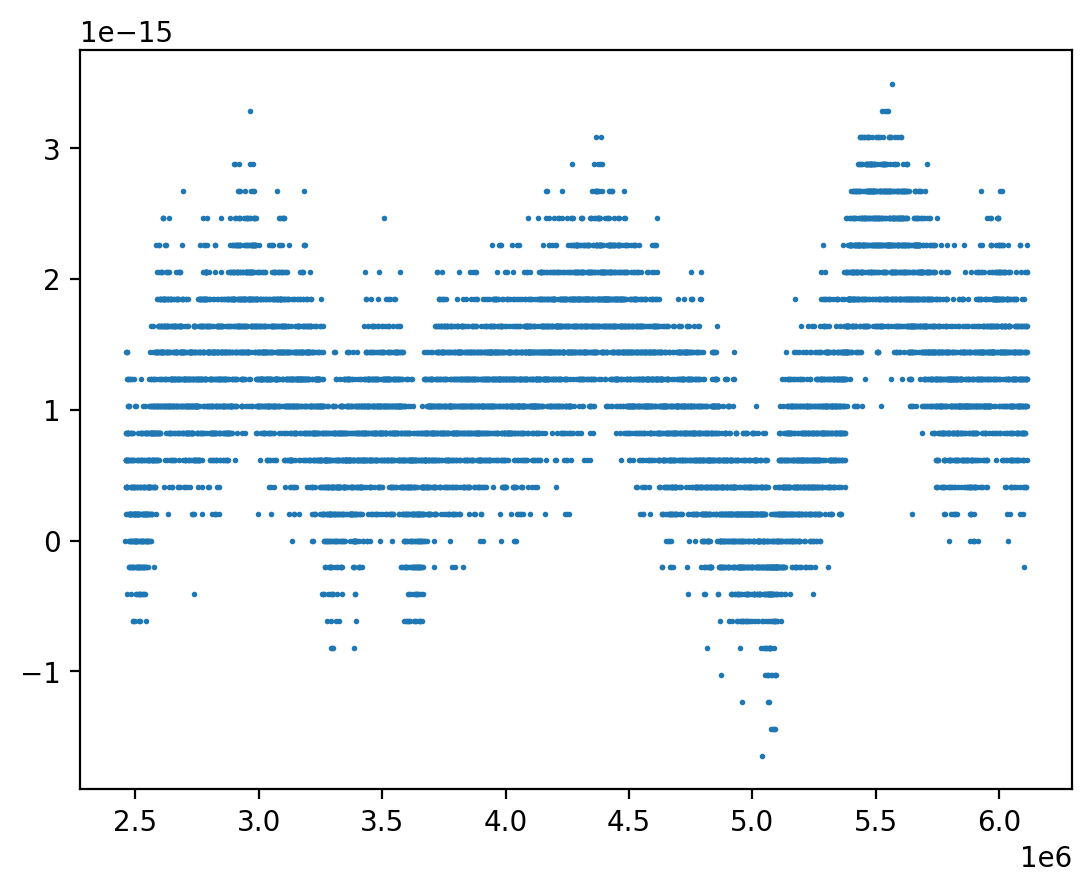

In [24]:
plt.scatter(epochs, (np.array(energies) - E0) / E0, s=1)